# Download Dataset

In this notebook, I use selenium to search for and then download images from google images. I use several variable search terms and save some metadata for each image.  

References ...
- https://www.geeksforgeeks.org/download-google-image-using-python-and-selenium/
- https://dev.to/ericchapman/python-get-and-save-google-images-with-selenium-42i1
- https://stackoverflow.com/a/52545788/2869043

In [1]:
import os
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options 
import requests
import time

In [2]:
# function for scrolling to the bottom of results
def scroll_to_bottom(driver, wait=3):

    last_height = driver.execute_script('\
    return document.body.scrollHeight')

    while True:
        driver.execute_script('\
        window.scrollTo(0,document.body.scrollHeight)')

        # wait for results to load
        time.sleep(wait)

        new_height = driver.execute_script('\
        return document.body.scrollHeight')

        # click on "Show more results" (if exists)
        try:
            driver.find_element_by_css_selector(".YstHxe input").click()

            # wait for results to load
            time.sleep(wait)

        except:
            pass

        # check for bottom of page
        if new_height == last_height:
            break

        last_height = new_height

In [3]:
# define variables of interest
all_species = ('orc', 'elf', 'dwarf', 'halfling', 'human', 'dragonborn', 'gnome', 'tiefling', 'goblin', 'drow')
all_classes = ('barbarian', 'bard', 'cleric', 'druid', 'fighter', 'monk', 'paladin', 'ranger', 'rogue', 'sorcerer', 'warlock', 'wizard')
all_genders = ('male', 'female', 'nonbinary')
n_per_category = 300

# define directory to store images
img_dir = '../data/raw'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)

meta_fname = f'{img_dir}/metadata.csv'
with open(meta_fname, 'w') as fout:
    fout.write('fname;url\n')

# create webdriver instance
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("no-sandbox")
chrome_options.add_argument("--disable-extensions")
chrome_options.add_argument("--headless")
driver_path = '/usr/bin/chromedriver'
driver = webdriver.Chrome(executable_path=driver_path, chrome_options=chrome_options)

# maximize the screen
driver.maximize_window()

/tmp/ipykernel_6198/1259476175.py:22: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=driver_path, chrome_options=chrome_options)
/tmp/ipykernel_6198/1259476175.py:22: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(executable_path=driver_path, chrome_options=chrome_options)


/tmp/ipykernel_6198/2816800009.py:16: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  box = driver.find_element_by_xpath('//*[@id="sbtc"]/div/div[2]/input')
/tmp/ipykernel_6198/3585868591.py:19: DeprecationWarning: find_element_by_css_selector is deprecated. Please use find_element(by=By.CSS_SELECTOR, value=css_selector) instead
  driver.find_element_by_css_selector(".YstHxe input").click()
/tmp/ipykernel_6198/2816800009.py:24: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  elements = driver.find_elements_by_class_name('rg_i')
/tmp/ipykernel_6198/2816800009.py:37: DeprecationWarning: find_elements_by_class_name is deprecated. Please use find_elements(by=By.CLASS_NAME, value=name) instead
  element = driver.find_elements_by_class_name('v4dQwb')
/tmp/ipykernel_6198/2816800009.py:41: DeprecationWarning: find_element_by_class_name is deprecat

No connection adapters were found for ''

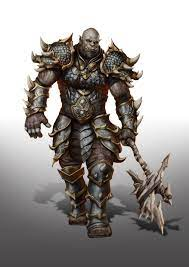

list index out of range
No connection adapters were found for ''
list index out of range
No connection adapters were found for ''

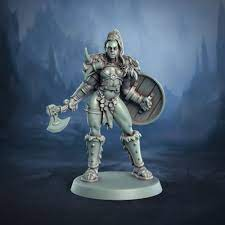
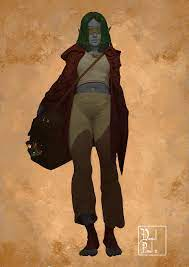

No connection adapters were found for ''
No connection adapters were found for ''

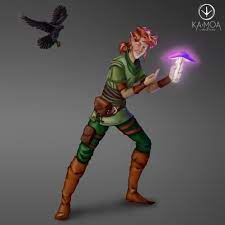
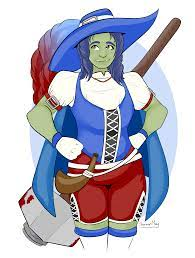

list index out of range
No connection adapters were found for ''

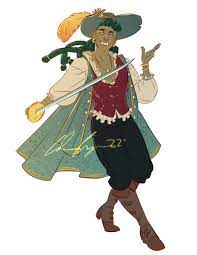

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/1400/92557d02-c70a-41d0-bda1-14b13c5ece3c.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/169cf524-da9a-4445-b12e-4b29959e730a.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

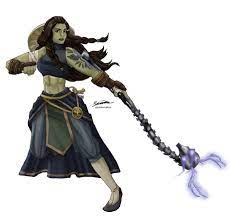

list index out of range
list index out of range
No connection adapters were found for ''

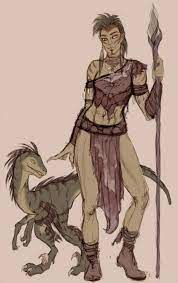

No connection adapters were found for ''

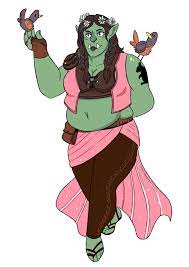

No connection adapters were found for ''

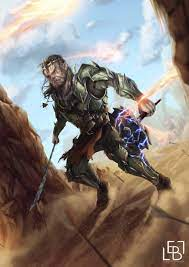

No connection adapters were found for ''

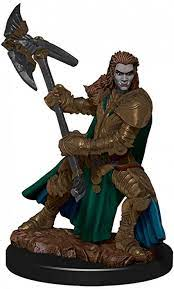

No connection adapters were found for ''

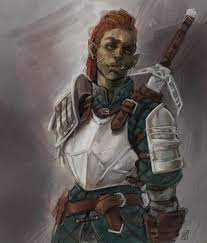

list index out of range
No connection adapters were found for ''

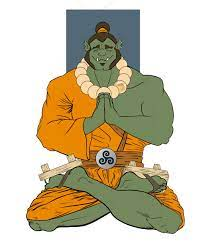

No connection adapters were found for ''

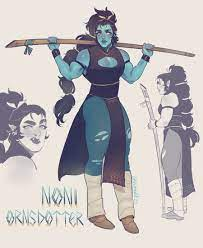

No connection adapters were found for ''

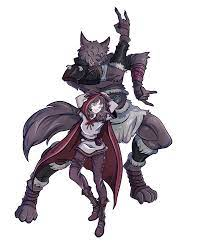

No connection adapters were found for ''

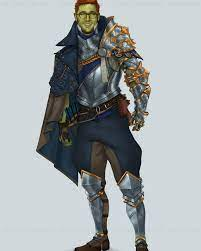

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/887/a28c47a1-59b1-466b-821d-21a3fb17f485.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

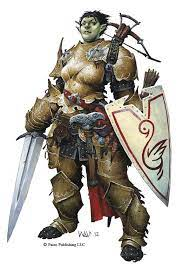

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/887/a28c47a1-59b1-466b-821d-21a3fb17f485.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/169cf524-da9a-4445-b12e-4b29959e730a.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/169cf524-da9a-4445-b12e-4b29959e730a.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were f
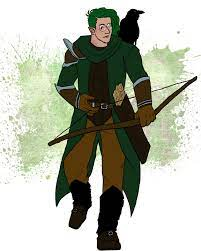

No connection adapters were found for ''

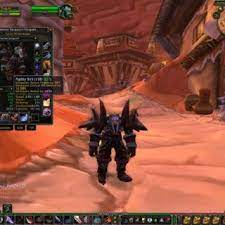

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/169cf524-da9a-4445-b12e-4b29959e730a.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='assets.dragoart.com', port=443): Max retries exceeded with url: /images/168254_502/how-to-draw-an-orc-warrior-step-18_5e4ccc91ab07e2.34405545_96518_5_3.gif (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''
No connection adapters were found for ''

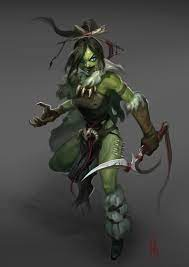
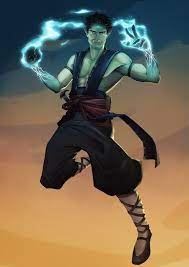

No connection adapters were found for ''
HTTPSConnectionPool(host='kinggames.dk', port=443): Max retries exceeded with url: /images/miniatures/vagorg_half_orc_sorcerer_60173_02-p.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f4be6b10e80>: Failed to establish a new connection: [Errno -3] Temporary failure in name resolution'))
list index out of range
No connection adapters were found for ''

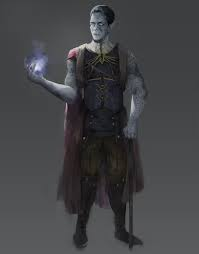
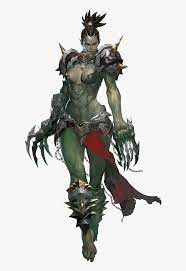

list index out of range
No connection adapters were found for ''

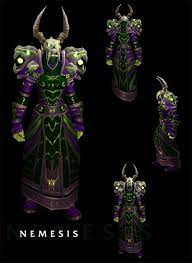

No connection adapters were found for ''
No connection adapters were found for ''

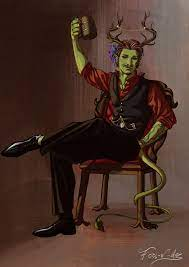
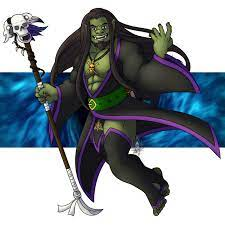

No connection adapters were found for ''

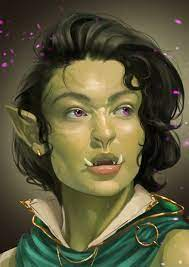

HTTPSConnectionPool(host='gatherer.wizards.com', port=443): Max retries exceeded with url: /Handlers/Image.ashx?multiverseid=567566&type=card (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

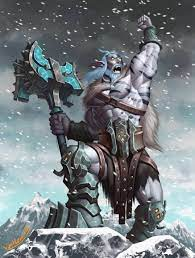

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/31879a05-f334-48dd-926c-1c7c76589cc6.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='wiki.project1999.com', port=443): Max retries exceeded with url: /images/Troubadours.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''
No connection adapters were found for ''

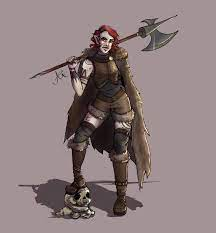
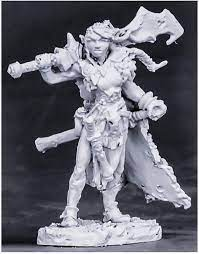

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/887/a28c47a1-59b1-466b-821d-21a3fb17f485.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

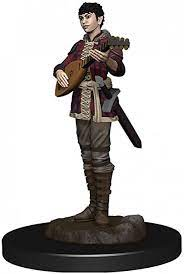

No connection adapters were found for ''
No connection adapters were found for ''

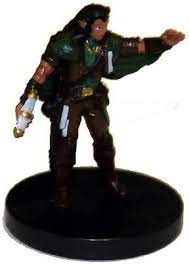
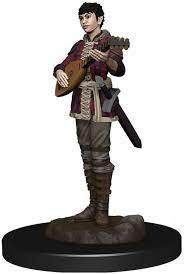

list index out of range
No connection adapters were found for ''

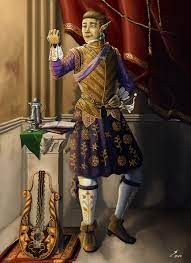

No connection adapters were found for ''

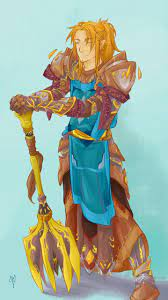

No connection adapters were found for ''

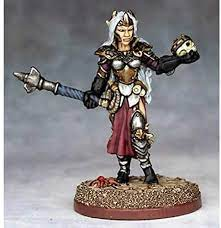

HTTPSConnectionPool(host='animesher.com', port=443): Max retries exceeded with url: /orig/0/0/1/12/animesher.com_cleric-girl-manga-1201.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

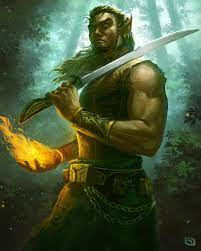

HTTPSConnectionPool(host='gatherer.wizards.com', port=443): Max retries exceeded with url: /Handlers/Image.ashx?multiverseid=366440&type=card (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''
No connection adapters were found for ''

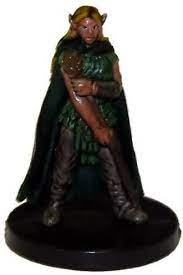
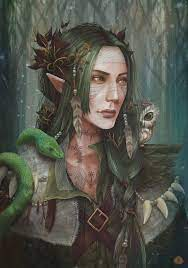

No connection adapters were found for ''

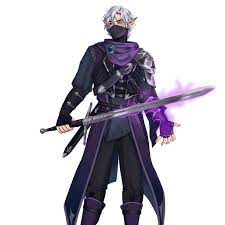

HTTPSConnectionPool(host='ironwindmetals.com', port=443): Max retries exceeded with url: /images/com_hikashop/upload/hackmaster/KC-4124-New.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''
No connection adapters were found for ''

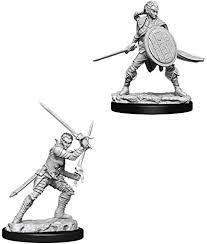
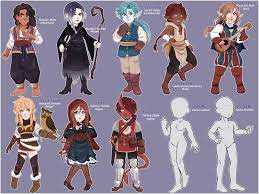

No connection adapters were found for ''

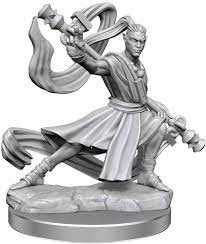

list index out of range
No connection adapters were found for ''

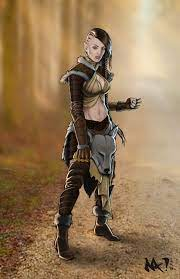

list index out of range
No connection adapters were found for ''

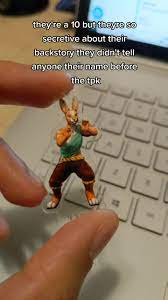

No connection adapters were found for ''

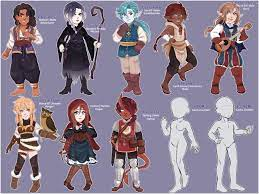

No connection adapters were found for ''
No connection adapters were found for ''

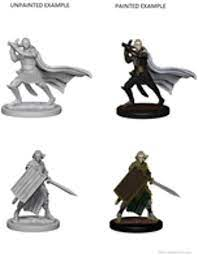
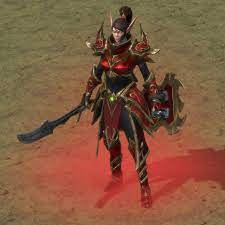

list index out of range
HTTPSConnectionPool(host='www.ironwindmetals.com', port=443): Max retries exceeded with url: /images/com_hikashop/upload/fantasy/DF-542.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
list index out of range
No connection adapters were found for ''

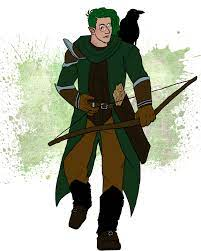

No connection adapters were found for ''

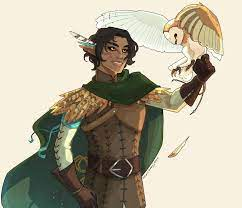

No connection adapters were found for ''

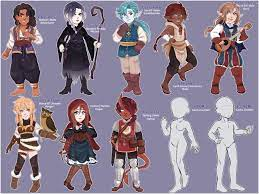

No connection adapters were found for ''
No connection adapters were found for ''

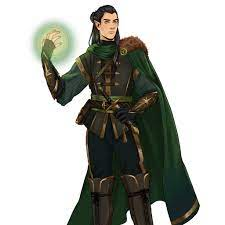
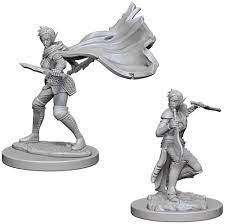

HTTPSConnectionPool(host='p.favim.com', port=443): Max retries exceeded with url: /orig/2018/10/25/concept-female-elf-illustration-Favim.com-6453023.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
list index out of range
No connection adapters were found for ''

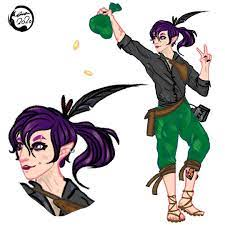

list index out of range
No connection adapters were found for ''

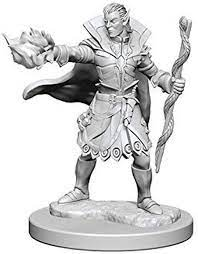

No connection adapters were found for ''
No connection adapters were found for ''

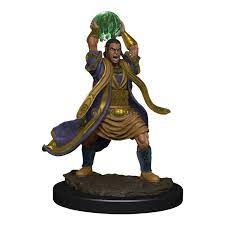
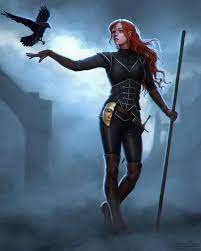

HTTPSConnectionPool(host='images.cults3d.com', port=443): Max retries exceeded with url: /Sc6J2lSM48y2fGKVj8tkEUZ_ZFA=/516x516/https://files.cults3d.com/uploaders/16234601/illustration-file/3138e0b4-0f8d-414b-aaca-0b6985e675bf/04.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1129)')))
No connection adapters were found for ''

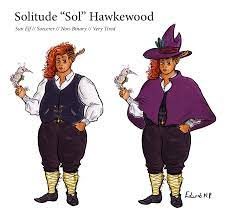

No connection adapters were found for ''
No connection adapters were found for ''

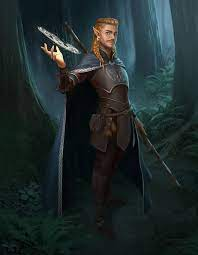
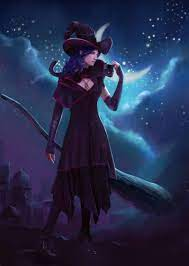

No connection adapters were found for ''

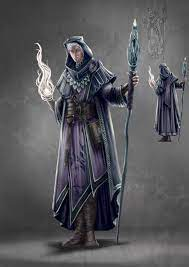

No connection adapters were found for ''
No connection adapters were found for ''

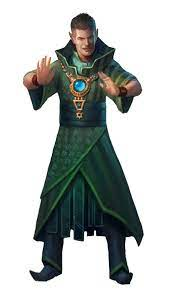
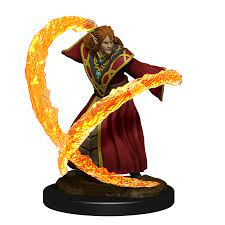

No connection adapters were found for ''

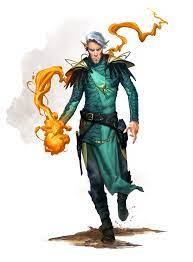

No connection adapters were found for ''

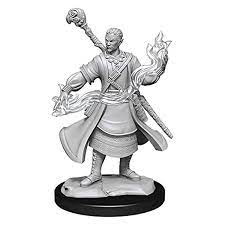

No connection adapters were found for ''

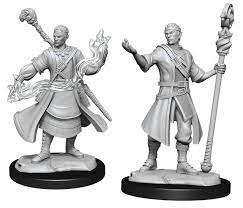

No connection adapters were found for ''

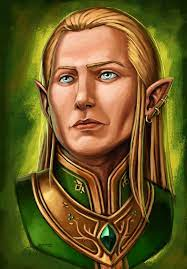

No connection adapters were found for ''
No connection adapters were found for ''

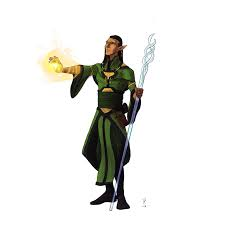
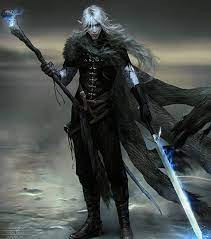

HTTPSConnectionPool(host='pbs.twimg.com', port=443): Max retries exceeded with url: /media/ES1i0W2WsAAIWkh.jpg:large (Caused by SSLError(SSLError(1, '[SSL: TLSV1_ALERT_INTERNAL_ERROR] tlsv1 alert internal error (_ssl.c:1129)')))
No connection adapters were found for ''

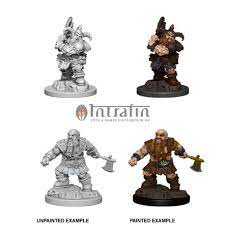

No connection adapters were found for ''

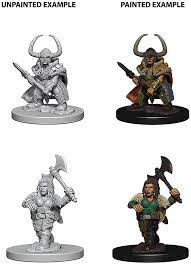

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/1537/e5cfdc21-6d93-4784-8ba8-dcf2f4dd4e25.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='im
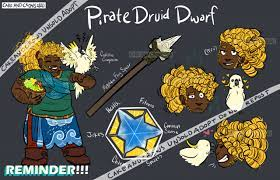

No connection adapters were found for ''
HTTPSConnectionPool(host='ironwindmetals.com', port=443): Max retries exceeded with url: /images/com_hikashop/upload/hackmaster/KC-4135-New.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))

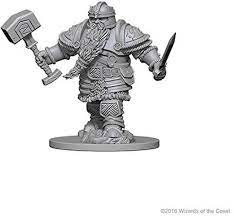

No connection adapters were found for ''

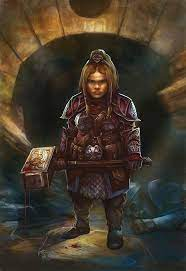

No connection adapters were found for ''
No connection adapters were found for ''

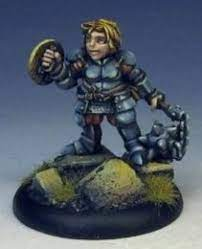
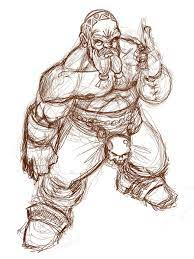

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/169cf524-da9a-4445-b12e-4b29959e730a.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/aac1d7ae-128e-4000-8cc5-eb0cc36a9d5e.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2565-home_default/dwarf-monk.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): 
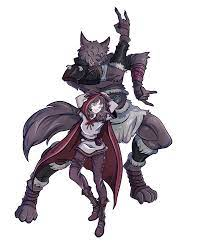

HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2556-large_default/dwarf-paladin.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/1529/c9201d7d-0335-4289-a945-e7d4d06ed9f9.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

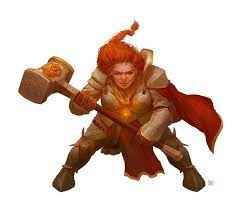

HTTPSConnectionPool(host='www.pantheonmmo.com', port=443): Max retries exceeded with url: /wp-content/themes/rise_of_the_fallen-child/assets/img/classes/humanpaladin.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2557-home_default/dwarf-paladin.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

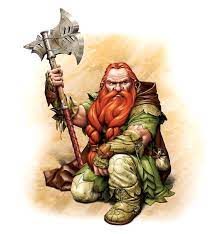

No connection adapters were found for ''

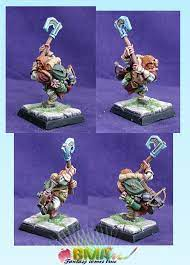

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/70d4ecfb-2cab-4a87-87ee-ae180459a109.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

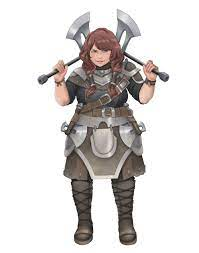

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/70d4ecfb-2cab-4a87-87ee-ae180459a109.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were fou
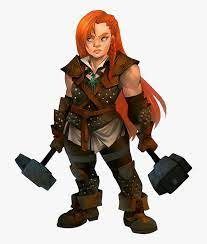

HTTPSConnectionPool(host='ironwindmetals.com', port=443): Max retries exceeded with url: /images/com_hikashop/upload/thumbnails/300x300c000000/fantasy/03-117-New.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

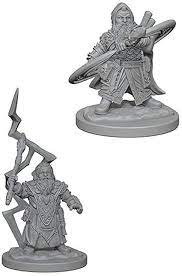

list index out of range
HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2542-home_default/dwarf-sorcerer.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
list index out of range
HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2534-home_default/dwarf-wizard.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''
HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2536-home_default/dwarf-warlock.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(
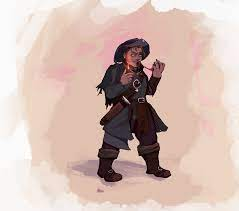
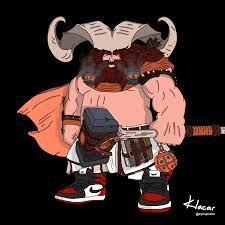

No connection adapters were found for ''

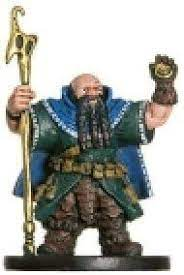

HTTPSConnectionPool(host='ironwindmetals.com', port=443): Max retries exceeded with url: /images/com_hikashop/upload/hackmaster/KC-4138.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/1096/448df12c-fb96-407f-b97d-5c89975058bc.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

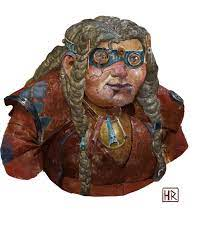

HTTPSConnectionPool(host='unreleasedminiatures.eu', port=443): Max retries exceeded with url: /2534-home_default/dwarf-wizard.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/1529/a2e74706-79d9-4e24-80d3-d3795b39aa80.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='lostarkgames.com', port=443):
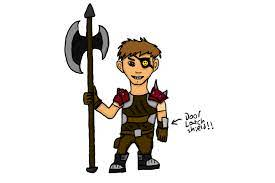

HTTPSConnectionPool(host='valhallaverse.com', port=443): Max retries exceeded with url: /assets/images/hero/3.webp (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /productimage/projects/1047/77d2564d-8894-4c04-8d91-4c830a9ffa1a.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''
No connection adapters were found for ''

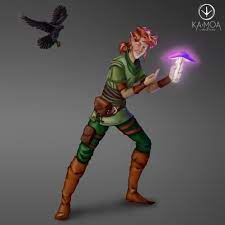
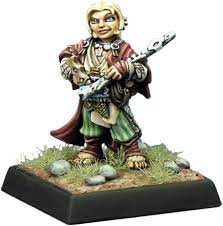

HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
list index out of range
HTTPSConnectionPool(host='wiki.project1999.com', port=443): Max retries exceeded with url: /images/thumb/Male_Halfling_Cleric-PoM_Armor.png/400px-Male_Halfling_Cleric-PoM_Armor.png (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (
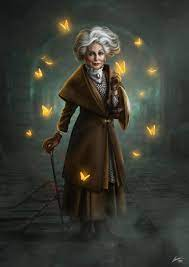
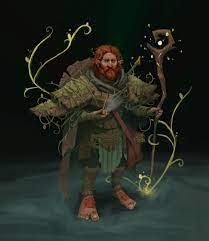

No connection adapters were found for ''

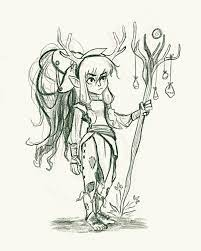

HTTPSConnectionPool(host='www.pantheonmmo.com', port=443): Max retries exceeded with url: /wp-content/themes/rise_of_the_fallen-child/assets/img/classes/halflingdruid.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='seforums.pantheonmmo.com', port=443): Max retries exceeded with url: /content/public/user/9c/c9/9e21224e23d77bfb5c7ba23b06e84975.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
No connection adapters were found for ''

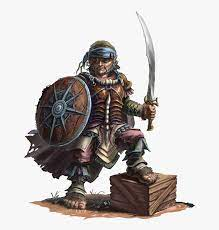

HTTPSConnectionPool(host='www.ironwindmetals.com', port=443): Max retries exceeded with url: /images/com_hikashop/upload/fantasy/03-160.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))
HTTPSConnectionPool(host='imgcdn.gamefound.com', port=443): Max retries exceeded with url: /extralarge/projects/689/47e7169d-de4d-4f6f-81ac-52fbc1237628.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))


In [ ]:
# list to store metadata
metadata = []

# iterate through search criteria
for species_ in all_species:
    for class_ in all_classes:
        for gender_ in all_genders:

            query = f'{species_} {class_} {gender_}'
            out_file = f'{img_dir}/{species_}_{class_}_{gender_}_%09d.jpg'

            # open google images
            driver.get('https://images.google.com/')

            # find the search box and query
            box = driver.find_element_by_xpath('//*[@id="sbtc"]/div/div[2]/input')
            box.send_keys(query)
            box.send_keys(Keys.ENTER)

            # scroll to the bottom of the results
            scroll_to_bottom(driver)

            # find image elements
            elements = driver.find_elements_by_class_name('rg_i')
            counter = 0
            
            for e in elements:
                try:
                    # create action chain object
                    action = ActionChains(driver)

                    # perform click operation
                    action.move_to_element(e).click().perform()

                    # get images source url
                    time.sleep(1)
                    element = driver.find_elements_by_class_name('v4dQwb')

                    # Google image web site logic
                    if counter == 0:
                        big_img = element[0].find_element_by_class_name('n3VNCb')
                    else:
                        big_img = element[1].find_element_by_class_name('n3VNCb')

                    url = big_img.get_attribute("src")

                    # write image to file
                    reponse = requests.get(url)
                    out_file_ = out_file % counter

                    if reponse.status_code == 200:
                        with open(out_file_, "wb") as file:
                            file.write(reponse.content)

                    with open(meta_fname, 'a') as fout:
                        fout.write(f'{out_file_};{url}\n')
                            
                except Exception as e:
                    print(e)

                counter += 1

                if counter == n_per_category:
                    break

driver.close()